In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

◼️1-1. センサは下図のような配置で前腕にしっかりと固着させる。
<center><figure>
    <img src="DSC_0628.JPG" width="300">
    <figcaption>図１．センサの取り付け</figcaption>
</figure></center>  
その後，上腕を鉛直に前腕と手を水平に（肘をほぼ直角に）保ちながら，固定した物体（例えば机の下部分）を全力で上に押すという状態を約３分間続ける。

◼️1-2. 計測データをデータフレーム`df`に読み込む：

In [2]:
df = pd.read_csv('0711TSND121-14011733_2019-07-11_163719.055.csv',
                 names=['item', 'time', 'a_x', 'a_y', 'a_z', 'u_x', 'u_y','u_z'])

In [3]:
df.head()

,item,time,a_x,a_y,a_z,u_x,u_y,u_z
0,ags,59839169,328,-10364,-433,131,255,15
1,ags,59839170,365,-10398,-411,143,249,27
2,ags,59839171,360,-10364,-543,143,242,27
3,ags,59839172,377,-10381,-538,156,255,15
4,ags,59839173,377,-10373,-436,156,261,15


In [4]:
df.tail()

,item,time,a_x,a_y,a_z,u_x,u_y,u_z
202906,ags,60042075,1493,-10249,-326,545,-805,-309
202907,ags,60042076,1510,-10232,-365,539,-830,-309
202908,ags,60042077,1512,-10276,-348,539,-866,-315
202909,ags,60042078,1527,-10332,-324,545,-885,-339
202910,ags,60042079,1537,-10256,-250,539,-897,-345


◼️1-3. 各データの長さ（要素数）は次の通り：

In [5]:
length_of_data = len(df)
print(length_of_data)

202911


◽︎1-3-1 分秒にして：

In [6]:
print(f'{int(length_of_data/1000//60)}分{(length_of_data/1000)%60}秒')

3分22.911秒


◼️1-4. 角速度の各成分を取り出して1D-numpy配列にしておく。ただし，単位を$\mathrm{G}(=9.806\mathrm{m/s^2})$にするため，各配列を10000で割っておく：

In [7]:
a_x = np.array(df['a_x'])/10
a_y = np.array(df['a_y'])/10
a_z = np.array(df['a_z'])/10

> センサで計測された加速度単位は$10^{-1}\mathrm{mG}=\frac{1}{10000}\mathrm{G}$であることに注意。

◼️1-5. 加速度の各成分の時系列グラフ：

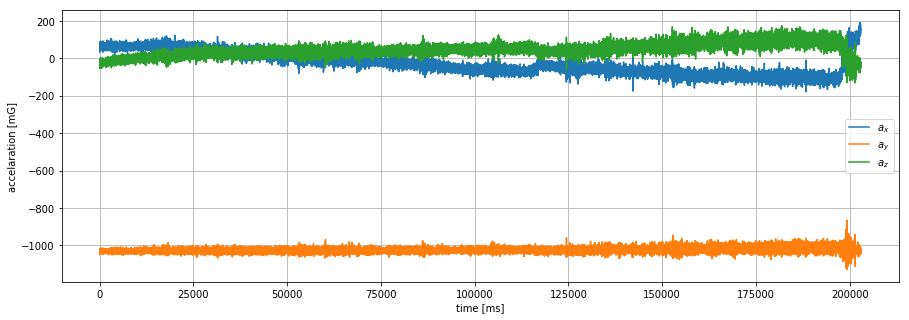

In [8]:
plt.figure(figsize=(15,5))
plt.plot(a_x)
plt.plot(a_y)
plt.plot(a_z)
plt.xlabel('time [ms]')
plt.ylabel('accelaration [mG]')
plt.legend(['$a_x$','$a_y$','$a_z$'])
plt.grid()

> 図１のように，y軸がほぼ鉛直下を向いているので，`a_y`が`-1[G]`付近で微小振動をしていることがわかる。残りの成分は`0[G]`付近で微小振動している。

◼️2-1. 周波数解析をするには，FFT(高速離散フーリエ変換)というアルゴリズム(プログラム)を使うが，この関数はありがたいことに`numpy`ライブラリの`fft`モジュール内にある。`np.fft.fft`という関数だ。マニュアルはセルに`np.fft.fft?`と入力て実行すれば表示される。詳しくはそれを読んでくれ。最も単純な使用方法のみ示しておこう：

***
### 【公式1】NumpyのFFT
サンプルリング周波数$H$Hzの時系列データ配列（1D-numpy配列が望ましい）で，うまく$2^n$（$n$は自然数）個の要素に切り取られた配列を`arr`とする。そのとき，Numpy関数`np.fft.fft`を用いて
```
F_arr = np.fft.fft(arr)/len(arr)
```
として得られた`F_arr`は，`arr`を離散**フーリエ変換**した配列である。ここで右辺の`F_arr`は`arr`と**同じ要素数**`len(arr)`$=2^n$の**複素数**を要素にもつ配列である。  
　　`k = 0, 1, 2, ...`に対して，`F_arr[k]`はデータ`arr`の周波数$\frac{H}{2^n}k$[Hz]のスペクトルとよばれる。なお，`F_arr[0]`は`arr`の平均値（実数）に等しく，直流成分とよばれる。
> 1. 厳密には，この時系列データは周期関数的に変動することが仮定されている。
2. `len(arr)`が$2^n$**でない**ときでも，関数`np.fft.fft`は`arr`のFFTを行う。しかし，より正確かつ高速にFFTを行うには，`len(arr)`$=2^n$であるのが望ましい（でなければならない）。
3. 離散フーリエ変換の定義の違いによって，配列`arr`の要素数`len(arr)`$=2^n$で除さないときもある。Numpyでは`len(arr)`$=2^n$で除さないものを離散フーリエ変換の定義にしていることに注意。
***

## FFTの解説 
　ここではコンピュータで扱う**高速離散フーリエ変換（FFT）**の解説を行うので，時系列データの**サンプリング数（要素数）を特殊なケースの$2^n$にとる**が，一般の離散フーリエ変換（DFT）のサンプリング数は$N(>H)$でよい（$H$はサンプリング周波数）。また，有名なオイラーの公式：$e^{i\theta}=\cos\theta+i\sin\theta$（ここで，$i=\sqrt{-1}$）を用いるが，この公式ぐらい暗記しておいても損はない。また，$e^{i\theta}$の複素共役は，$\cos\theta-i\sin\theta=\cos(-\theta)+i\sin(-\theta)=e^{-i\theta}$であることも付け加えておく。  

　簡単のため，サンプリング開始時刻$t_0$を$0$とし，十分大きな$2^n$（$n$は自然数）をとって，サンプリング周波数$H$のデータの時刻$t$が，等間隔に$t$ $\simeq \{ t_0, t_1, t_2, ...,t_l,..., t_{2^n-1} \}$ $=\{ 0, t_1, t_2, ...,t_l,..., t_{2^n-1} \}$と離散化されているとする。ここで，$\tau$ $:=$ $1/H$ $=t_1-t_0$ $(=t_1-0)$ $=t_2-t_1$ $=...=t_l-t_{l-1}$ $=...=t_{2^n-1}-t_{2^n-2}$とおく。そうすると，実数データ$\xi(t)$も離散化されて，$\xi = \xi(t)$ $\simeq \{\xi(t_0), \xi(t_1), \xi(t_2), ..., \xi(t_l),...,\xi(t_{2^n-1}) \}$ $= \{\xi(0), \xi(\tau), \xi(2\tau), ..., \xi(l\tau),...,\xi((2^n-1)\tau) \}$$=:\{\xi_0, \xi_1, \xi_2, ..., \xi_l,...,\xi_{2^n-1} \}$となる。

　さて，$\xi_l\ \ (l=0,1,2,...,2^{n}-1)$は，

$$
\xi_l=F_0+F_1e^{2\pi i\frac{1l}{2^n}}+F_2e^{2\pi i\frac{2l}{2^n}}+...
+F_ke^{2\pi i\frac{kl}{2^n}}+...+F_{2^n-1}e^{2\pi i\frac{(2^n-1)l}{2^n}}
\tag{1}
=\sum_{k=0}^{2^n-1}F_ke^{2\pi i\frac{kl}{2^n}}
$$

と分解できることがわかっている。ここで，$l$はデータ番号といわれ，時刻$t_0+l\tau$データを表す添字である。この$F_k$を，データ$\xi$の周波数$\frac{H}{2^n}k(=\frac{1}{2^n \tau}k)$のスペクトルといい，$(1)$をフーリエ逆変換という。  
　$F_0$は実数で

$$F_0=\frac{1}{2^n}(\xi_0+\xi_1+\xi_2+...+\xi_{2^{n-1}}+...+\xi_{2^n-1})\\
=\frac{1}{2^n}\sum_{k=0}^{2^n-1}\xi_{k}=:a_0. \tag{2}$$

つまり$F_0=a_0$は全データの平均であり，したがって実数である。  
　$F_0$を除いた$\{F_1, F_2, ..., F_{2^n}\}$のちょうど中間に位置する$F_{2^{n-1}}(=F_{\frac{2^n}{2}})$もまた実数で，

$$F_{2^{n-1}}=\frac{1}{2^n}(\xi_0-\xi_1+\xi_2-\xi_3+...-\xi_{2^{n-1}-1}+\xi_{2^{n-1}}-\xi_{2^{n-1}+1}+...+\xi_{2^n-2}-\xi_{2^n-1})\\
=\frac{1}{2^n}\sum_{k=0}^{2^n-1}(-1)^k\xi_{k}=:a_{2^{n-1}} \tag{3}$$

で与えられる。これをスペクトルのナイキスト成分といい，このときの周波数$\frac{H}{2}=\frac{1}{2\tau}$をナイキスト周波数とよぶ。$(1)$における，$F_{2^{n-1}}=a_{2^{n-1}}$の係数は

$$
e^{2\pi i\frac{2^{n-1}l}{2^n}}=\cos(2\pi \frac{2^{n-1}l}{2^n})+i\sin(2\pi \frac{2^{n-1}l}{2^n})=\cos(\pi l)=(-1)^l \tag{4}
$$

で，これも実数である。 ここで，$\sin(\pi l)=0$に注意せよ。後の便宜のため，$(1)$における$F_{2^{n-1}}$の項を

$$
F_{2^{n-1}}e^{2\pi i\frac{2^{n-1}l}{2^n}}=a_{2^{n-1}}\cos(\pi l)
=a_{2^{n-1}}\cos(2\pi \frac{2^{n-1}l}{2^n})+ib_{2^{n-1}}\sin(2\pi \frac{2^{n-1}l}{2^n}) \tag{5}
$$

としておこう。  
　その他の$F_k$は一般的に複素数なので，

$$F_k =: a_k-ib_k \tag{6}$$ 

とおける。ここで，$a_k,\ b_k$は実数。そうすると，

$$
a_k=\frac{1}{2^n}\sum_{l=0}^{2^n-1} \xi_l \cos(\frac{2\pi kl}{2^n}),\ \ 
b_k=\frac{1}{2^n}\sum_{l=0}^{2^n-1} \xi_l \sin(\frac{2\pi kl}{2^n}) \tag{7}
$$

と書けることがわかっている。$(7)$の２つの式の右辺は気にするな。重要なのは，$0<k<2^{n-1}$で  

$$F_{2^n-k}=\overline{F_k}=a_k+ib_k \tag{8}$$

となることだ（$\cos$が偶関数，$\sin$が奇関数からこのことはほとんど自明）。ここで，記号の上に引いてあるバーは，それの複素共役を示している。$(8)$の関係式は，$(1)$の$a_0,\ a_{2^{n-1}}$の項以外の項の和が実数てあることを保証する（エルミート性）。実際，$(1)$における$F_k$の項と$F_{2^n-k}$の項の和は，

$$
F_{k}e^{2\pi i\frac{kl}{2^n}}+F_{2^n-k}e^{2\pi i\frac{(2^n-k)l}{2^n}}
=F_{k}e^{2\pi i\frac{kl}{2^n}}+\overline{F_k}e^{-2\pi i\frac{kl}{2^n}}
=F_{k}e^{2\pi i\frac{kl}{2^n}}+\overline{F_ke^{2\pi i\frac{kl}{2^n}}}\\
=2a_k\cos(\frac{2\pi kl}{2^n})+2b_k\sin(\frac{2\pi kl}{2^n}) \tag{9}
$$

となり，実数である。  
　$(2),(3),(5),(9)$から，$(1)$は

$$
\xi_l = \xi(l\tau) =\xi(t_l)
\\
$$

$$
=a_0 +
\bigr\{2a_1\cos(\frac{2\pi 1l}{2^n})+2b_1\sin(\frac{2\pi 1l}{2^n})\bigr\}+
\bigr\{2a_2\cos(\frac{2\pi 2l}{2^n})+2b_2\sin(\frac{2\pi 2l}{2^n})\bigr\}+...\\
...+\bigr\{2a_k\cos(\frac{2\pi kl}{2^n})+2b_k\sin(\frac{2\pi kl}{2^n})\bigr\}+
...+\bigr\{2a_{2^{n-1}}\cos(\frac{2\pi 2^{n-1}l}{2^n})+2b_{2^{n-1}}\sin(\frac{2\pi 2^{n-1}l}{2^n})\bigr\}\\
$$

$$
=a_0 +
\bigr\{2a_1\cos(2\pi\frac{H}{2^n}t_l)+2b_1\sin(2\pi\frac{H}{2^n}t_l)\bigr\}+
\bigr\{2a_2\cos(2\pi\frac{2H}{2^n}t_l)+2b_2\sin(2\pi\frac{2H}{2^n}t_l)\bigr\}+...\\
...+\bigr\{2a_k\cos(2\pi\frac{kH}{2^n}t_l)+2b_k\sin(2\pi\frac{kH}{2^n}t_l)\bigr\}+...\\
...+\bigr\{2a_{2^{n-1}}\cos(2\pi\frac{2^{n-1}H}{2^n}t_l)+2b_{2^{n-1}}\sin(2\pi\frac{2^{n-1}H}{2^n}t_l)\bigr\}  \tag{10}
$$

ここで，$H=1/\tau,\ l\tau=t_l\ \rightarrow \ l=Ht_l$を使った。$(10)$より，離散時系列データ$\xi$の任意の時刻$t_l$におけるデータ点$\xi_l$は，サンプリング時間における$\xi$の平均$a_0$(周波数$0$の波)と，$k=1,2,...,2^{n-1}$として，**周波数$\frac{kH}{2^n}$をもつ振幅$2a_k$の余弦波と振幅$2b_k$の正弦波の和として展開できる**ことが解った。  

　このように $F_0,F_1,...,F_{2^{n}-1}$ は，回路またはコンピュータ上で，離散データを$(1)$または$(10)$のように展開したとき，サンプリングデータの全時刻における**平均**と**取り得る周波数の余弦波と正弦波のそれぞれの振幅の$\frac{1}{2}$を複素数を用いて表すことに等しい**。式で書くと（気にするな）：

$$
F_k=\sum_{l=0}^{2^n-1}\xi_le^{2\pi i\frac{k}{2^n}l}=\sum_{l=0}^{2^n-1}\xi_le^{2\pi i\frac{kH}{2^n}l\tau}
\ \ \ (k=0,1,2,...,2^n-1)\\
\mathrm{or}\\
F(\frac{kH}{2^n})=\sum_{l=0}^{2^n-1}\xi(t_l)e^{2\pi i\frac{kH}{2^n}t_l} \tag{11}.
$$

式$(11)$を高速離散フーリエ変換(FFT)という。  
 こうして，【公式１】は，要素数$2^n$のデータ`arr`について，  
 - `F_arr[0]`は`arr`の平均を与える。
 - `F_arr[1]`は周波数$\frac{H}{2^n}$の`arr`の余弦波(実数成分)の振幅の$\frac{1}{2}$と正弦波の振幅(虚数成分)の$\frac{1}{2}$を与える。
 - `F_arr[2]`は周波数$\frac{2H}{2^n}$の`arr`の余弦波(実数成分)の振幅の$\frac{1}{2}$と正弦波(虚数成分)の振幅の$\frac{1}{2}$を与える。
 - ...
 - `F_arr[` $k$ `]`は周波数$\frac{kH}{2^n}$の`arr`の余弦波(実数成分)の振幅の$\frac{1}{2}$と正弦波(虚数成分)の振幅の$\frac{1}{2}$を与える。
 - ...
 - `F_arr[` $2^{n-1}$ `]`は周波数$\frac{H}{2^{n-1}}$（**ナイキスト周波数**）の`arr`の余弦波(実数成分)の振幅の$\frac{1}{2}$と正弦波(虚数成分)の振幅の$\frac{1}{2}$を与える。
 - これ以降は`F_arr[` $2^{n-1}-1$ `]`, ... , `F_arr[1]`の複素共役である。
 ***

◼️2-2

In [10]:
np.mean(a_x[:2**4])

39.931250000000006

In [11]:
b=np.array(
    [1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,-1])

In [12]:
np.mean(a_x[:2**4]*b)

-0.96875

In [13]:
print(np.fft.fft(a_y[:2**4]/2**4)[:2**3+1])

[-1.03835625e+03+0.j         -4.93332854e-01-1.27977063j
  3.27458739e-01+0.36762378j  8.39444468e-02-0.20864124j
 -7.50000000e-02-0.11875j     5.47040919e-02+0.11551505j
  4.60041261e-01+0.03012378j  1.54684315e-01-0.03061434j
  9.31250000e-01+0.j        ]


In [14]:
print('aaa')
pd.DataFrame({
    'サンプリング周波数[Hz]':np.ones(11)*1000,
    '２の冪($n$)':np.arange(10,21), 
    '時間窓($2^n$)[ms]':2**np.arange(10,21), 
    'FFT周波数間隔[Hz]':1000/2**np.arange(10,21),
    'FFT有効最大周波数[Hz]':500-1000/2**np.arange(10,21)})

aaa


,サンプリング周波数[Hz],２の冪($n$),時間窓($2^n$)[ms],FFT周波数間隔[Hz],FFT有効最大周波数[Hz]
0,1000.0,10,1024,0.976562,499.023438
1,1000.0,11,2048,0.488281,499.511719
2,1000.0,12,4096,0.244141,499.755859
3,1000.0,13,8192,0.122070,499.877930
4,1000.0,14,16384,0.061035,499.938965
5,1000.0,15,32768,0.030518,499.969482
6,1000.0,16,65536,0.015259,499.984741
7,1000.0,17,131072,0.007629,499.992371
8,1000.0,18,262144,0.003815,499.996185
9,1000.0,19,524288,0.001907,499.998093


In [15]:
def hz_vector(arr):
    return 1000 * np.arange(l)/len(arr)

In [16]:
2**(len(format(60000, 'b')))

65536

In [17]:
l = len(a_x)
lis = []
for i in range(0, l, 10000):
    if i+2**15 > l:
        break
    lis.append([i, i+2**15])
print(lis)

[[0, 32768], [10000, 42768], [20000, 52768], [30000, 62768], [40000, 72768], [50000, 82768], [60000, 92768], [70000, 102768], [80000, 112768], [90000, 122768], [100000, 132768], [110000, 142768], [120000, 152768], [130000, 162768], [140000, 172768], [150000, 182768], [160000, 192768], [170000, 202768]]


In [18]:
hz_vector(a_y[50:10000])

array([0.00000000e+00, 1.00502513e-01, 2.01005025e-01, ...,
       2.03927638e+04, 2.03928643e+04, 2.03929648e+04])

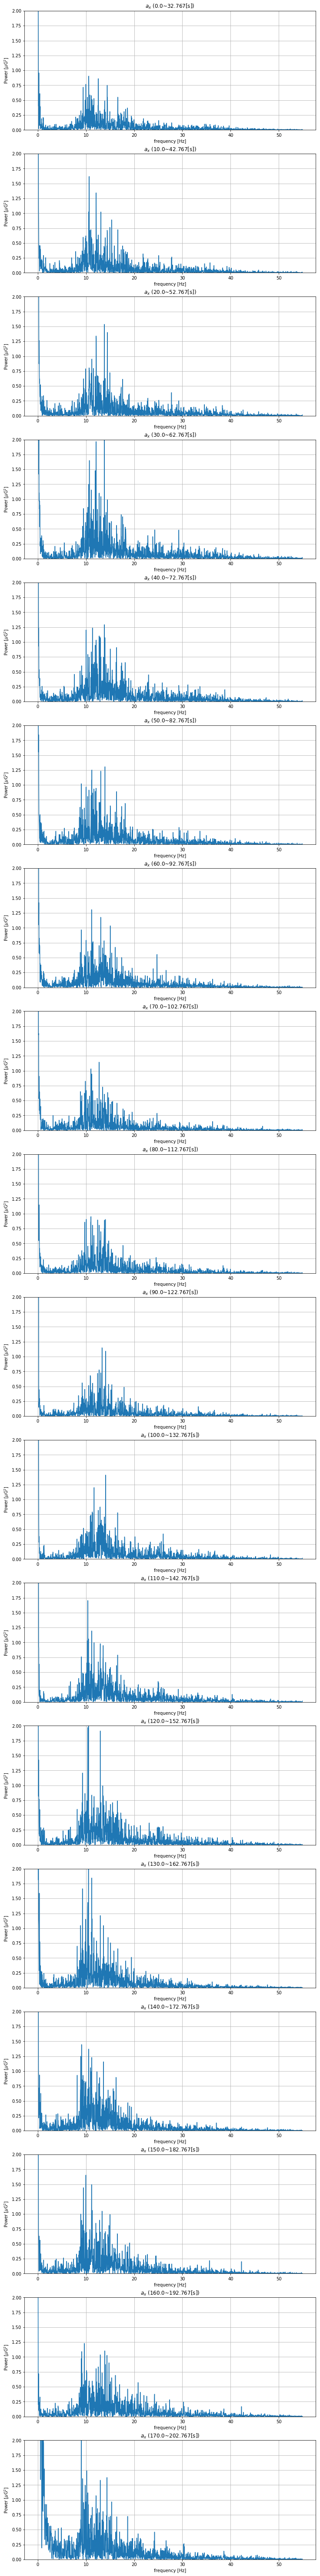

In [22]:
j = 1
plt.figure(figsize=(12,6*18))
for i in lis:
    F_a_ = np.fft.fft(a_x[i[0]:i[1]])/(i[1]-i[0])
    plt.subplot(18, 1, j)
    plt.plot(hz_vector(F_a_)[:1800], abs(F_a_)[:1800]**2)
    plt.ylim([0, 2])
    plt.title(f'$a_x$ ({i[0]/1000}~{(i[1]-1)/1000}[s])')
    plt.xlabel('frequency [Hz]')
    plt.ylabel('Power [$\mu \mathrm{G}^2$]')
    plt.grid()
    #plt.show()
    j += 1

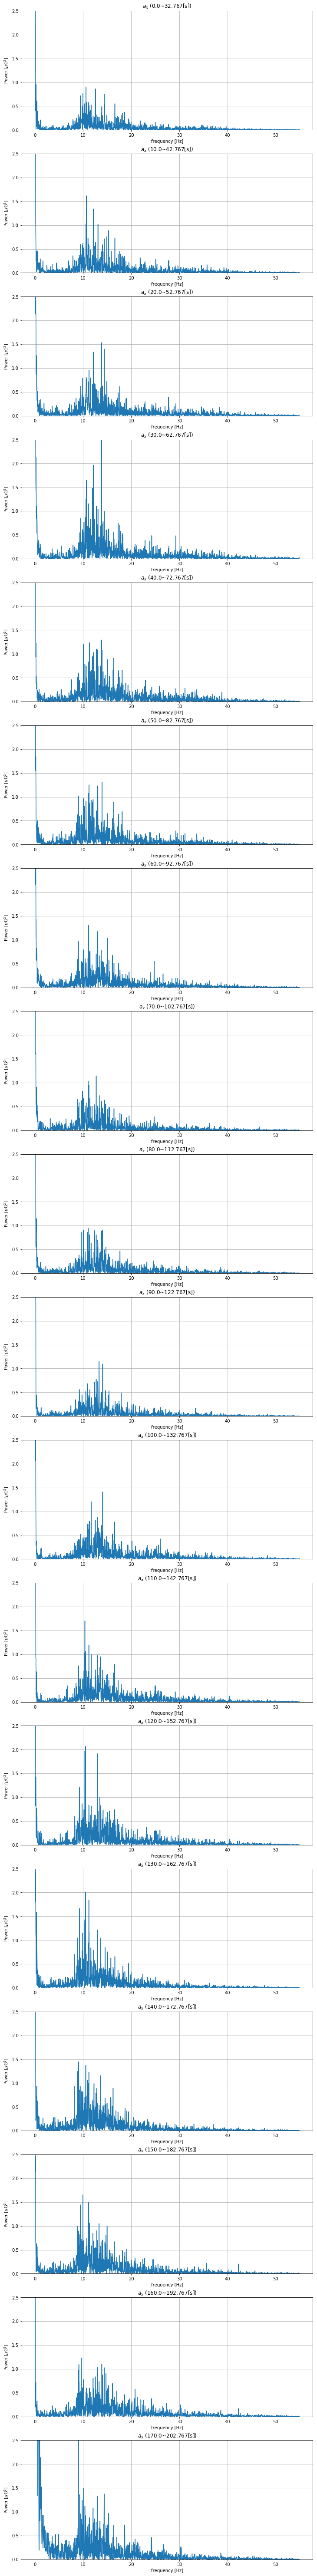

In [27]:
j = 1
plt.figure(figsize=(12,6*18))
for i in lis:
    F_a_ = np.fft.fft(a_x[i[0]:i[1]])/(i[1]-i[0])
    plt.subplot(18, 1, j)
    plt.plot(hz_vector(F_a_)[:1800], abs(F_a_)[:1800]**2)
    plt.ylim([0, 2.5])
    plt.title(f'$a_x$ ({i[0]/1000}~{(i[1]-1)/1000}[s])')
    plt.xlabel('frequency [Hz]')
    plt.ylabel('Power [$\mu \mathrm{G}^2$]')
    plt.grid()
    #plt.show()
    j += 1

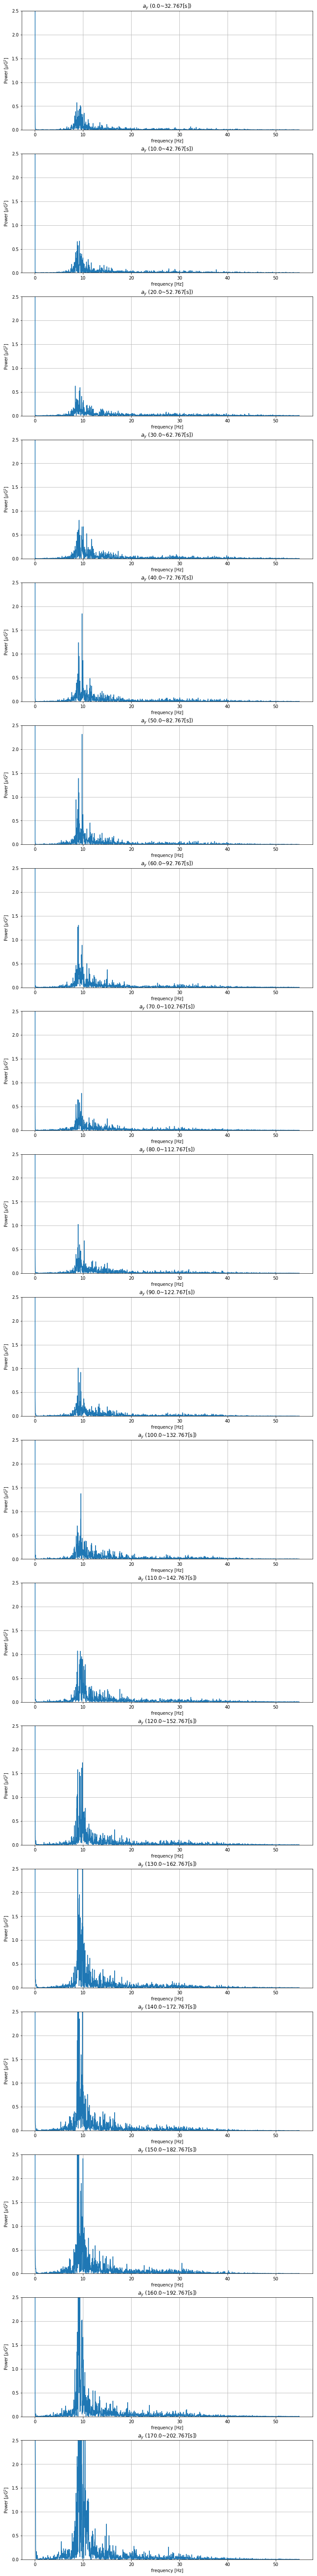

In [29]:
j = 1
plt.figure(figsize=(12,6*18))
for i in lis:
    F_a_ = np.fft.fft(a_y[i[0]:i[1]])/(i[1]-i[0])
    plt.subplot(18, 1, j)
    plt.plot(np.fft.fftfreq(2**15, d=0.001)[:1800], abs(F_a_)[:1800]**2)
    plt.ylim([0, 2.5])
    plt.title(f'$a_y$ ({i[0]/1000}~{(i[1]-1)/1000}[s])')
    plt.xlabel('frequency [Hz]')
    plt.ylabel('Power [$\mu \mathrm{G}^2$]')
    plt.grid()
    #plt.show()
    j += 1

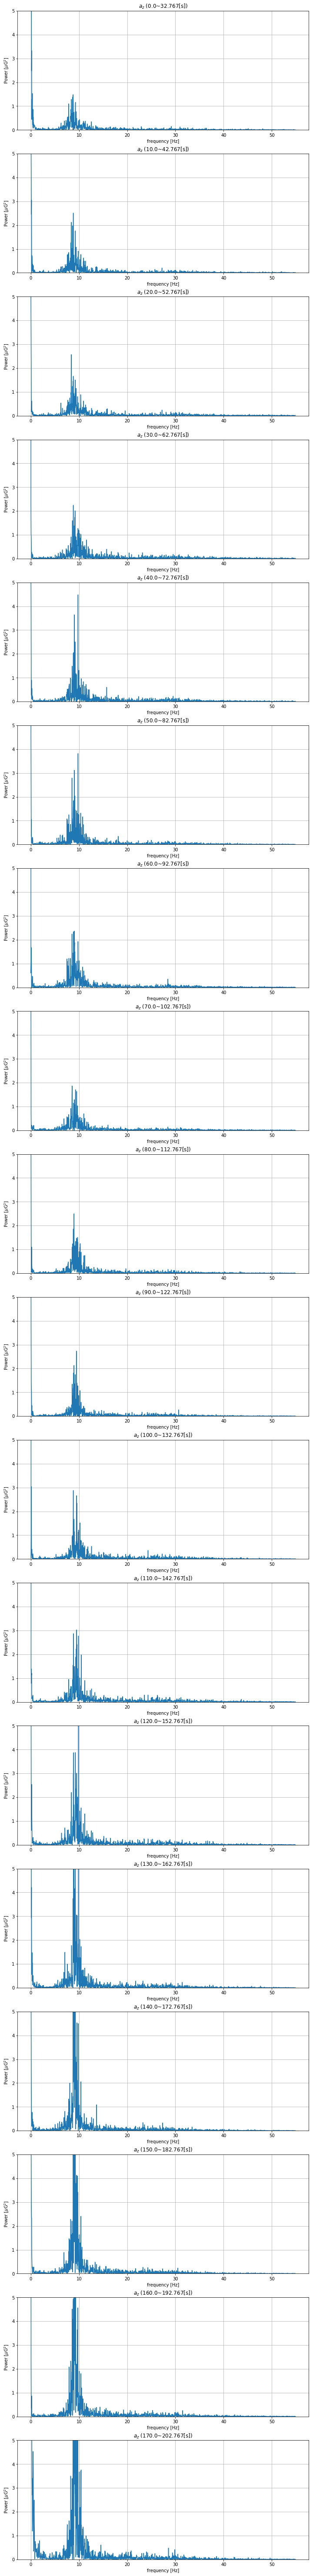

In [32]:
j = 1
plt.figure(figsize=(12,6*18))
for i in lis:
    F_a_ = np.fft.fft(a_z[i[0]:i[1]])/(i[1]-i[0])
    plt.subplot(18, 1, j)
    plt.plot(hz_vector(F_a_)[:1800], abs(F_a_)[:1800]**2)
    plt.ylim([0, 5])
    plt.title(f'$a_z$ ({i[0]/1000}~{(i[1]-1)/1000}[s])')
    plt.xlabel('frequency [Hz]')
    plt.ylabel('Power [$\mu \mathrm{G}^2$]')
    plt.grid()
    #plt.show()
    j += 1

In [119]:
hz_vector(F_a_y)

array([0.00000000e+00, 7.62939453e-03, 1.52587891e-02, ...,
       9.99977112e+02, 9.99984741e+02, 9.99992371e+02])

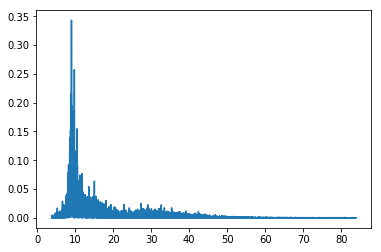

In [120]:
plt.plot(hz_vector(F_a_y)[500:11000], np.abs(F_a_y[500:11000])**2)

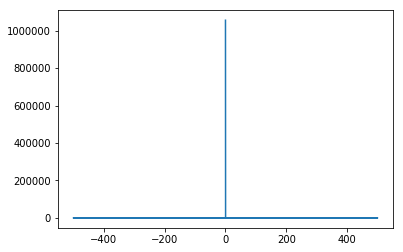

In [212]:
plt.plot(np.fft.fftfreq(2**17, d=0.001), np.abs(F_a_y)**2)

In [213]:
np.fft.fftfreq(2**17, d=0.001)

array([ 0.        ,  0.00762939,  0.01525879, ..., -0.02288818,
       -0.01525879, -0.00762939])

In [121]:
hz_vector(F_a_y)[500+np.where(np.abs(F_a_y[500:11000]**2)==np.max(np.abs(F_a_y[500:11000]**2)))[0][0]]

9.02557373046875

In [122]:
F_a_z = np.fft.fft(arr2power(a_z))/len(arr2power(a_z))

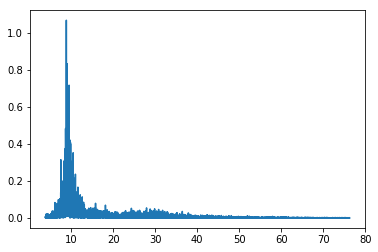

In [133]:
plt.plot(hz_vector(F_a_z)[500:10000], np.abs(F_a_z[500:10000])**2)

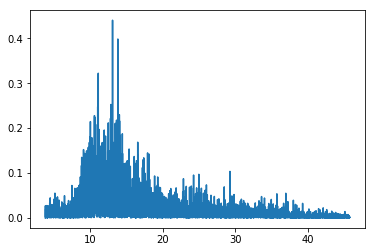

In [134]:
plt.plot(hz_vector(F_a_x)[500:6000], np.abs(F_a_x[500:6000])**2)

In [82]:
c = list(zip(range(0, length_of_data, 10000), range(2**15, length_of_data, 10000)))

In [83]:
c

[(0, 32768),
 (10000, 42768),
 (20000, 52768),
 (30000, 62768),
 (40000, 72768),
 (50000, 82768),
 (60000, 92768),
 (70000, 102768),
 (80000, 112768),
 (90000, 122768),
 (100000, 132768),
 (110000, 142768),
 (120000, 152768),
 (130000, 162768),
 (140000, 172768),
 (150000, 182768),
 (160000, 192768),
 (170000, 202768)]

In [84]:
np.arange(c[0][0], c[0][1])

array([    0,     1,     2, ..., 32765, 32766, 32767])

In [142]:
aax = np.fft.fft(a_x[:32])

In [143]:
print(aax)

[1439.5         +0.j           48.81061001 +97.03231123j
   -8.13086288+100.41509178j  -35.97057095 +39.33634226j
  -25.70208153 +41.67091988j  -14.1091055  +24.80989633j
   13.03405687 +13.66994421j  -39.70709597 +16.87951382j
   -3.         +14.3j         -24.841133   +13.85427542j
  -21.6843094  +12.09378987j  -12.25043329  +3.09564488j
  -23.29791847  +6.27091988j   -9.91740828 -15.92046323j
  -10.41888459  +7.23893744j  -15.21486303  +3.6645188j
  -25.1         +0.j          -15.21486303  -3.6645188j
  -10.41888459  -7.23893744j   -9.91740828 +15.92046323j
  -23.29791847  -6.27091988j  -12.25043329  -3.09564488j
  -21.6843094  -12.09378987j  -24.841133   -13.85427542j
   -3.         -14.3j         -39.70709597 -16.87951382j
   13.03405687 -13.66994421j  -14.1091055  -24.80989633j
  -25.70208153 -41.67091988j  -35.97057095 -39.33634226j
   -8.13086288-100.41509178j   48.81061001 -97.03231123j]


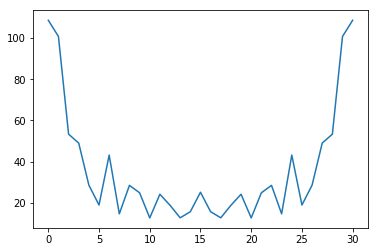

In [144]:
plt.plot(np.abs(aax[1:]))

In [162]:
np.arange(0, 202911, 10000)

array([     0,  10000,  20000,  30000,  40000,  50000,  60000,  70000,
        80000,  90000, 100000, 110000, 120000, 130000, 140000, 150000,
       160000, 170000, 180000, 190000, 200000])

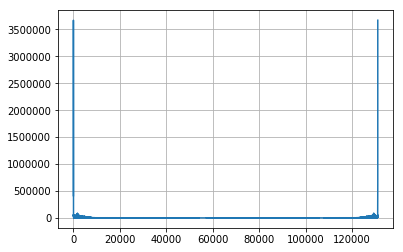

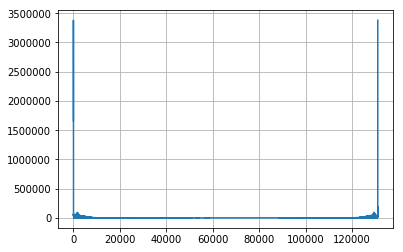

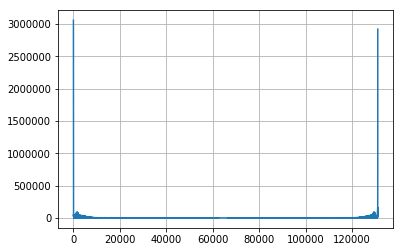

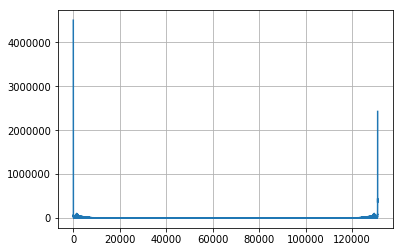

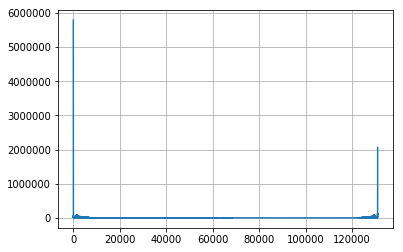

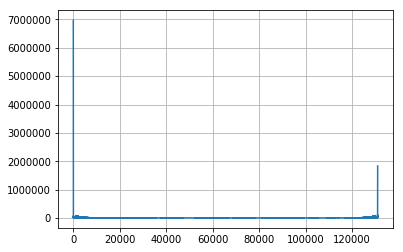

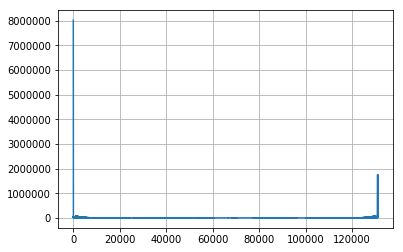

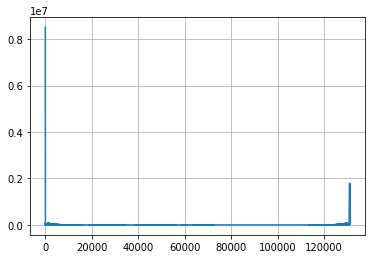

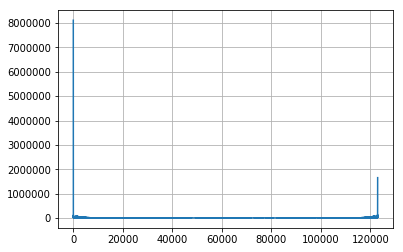

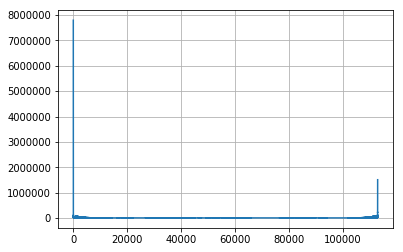

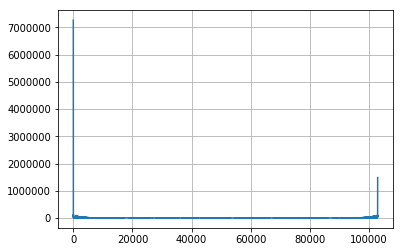

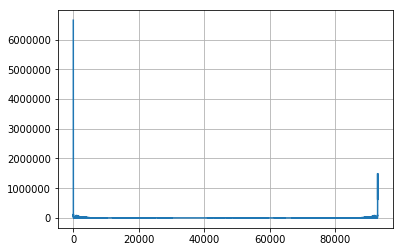

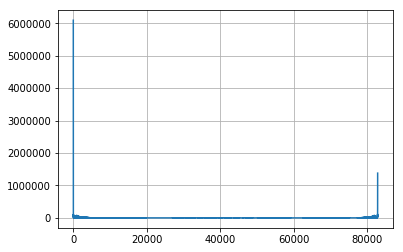

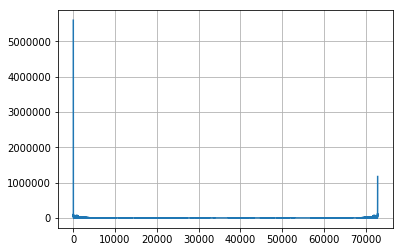

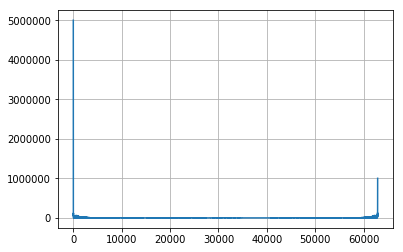

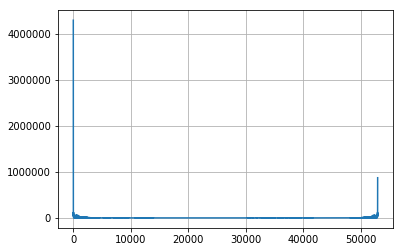

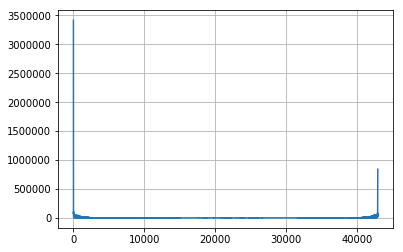

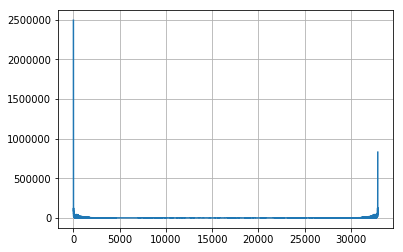

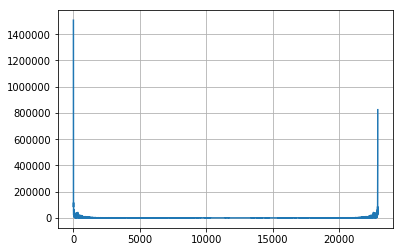

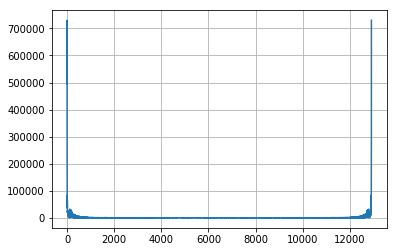

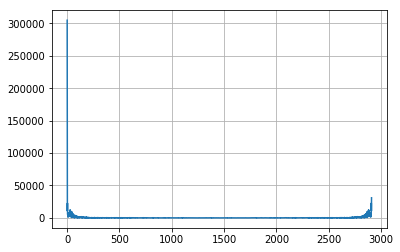

In [174]:
for p in np.arange(0, len(a_x), 10000):
    A_x = np.fft.fft(a_x[p : p+2**17])
    plt.plot(np.abs(A_x))
    plt.grid()
    plt.show()

In [176]:
len(A_x)

2911

In [177]:
np.arange(0, len(a_x), 10000)

array([     0,  10000,  20000,  30000,  40000,  50000,  60000,  70000,
        80000,  90000, 100000, 110000, 120000, 130000, 140000, 150000,
       160000, 170000, 180000, 190000, 200000])

In [195]:
list(range(2**15, len(a_x), 10000))

[32768,
 42768,
 52768,
 62768,
 72768,
 82768,
 92768,
 102768,
 112768,
 122768,
 132768,
 142768,
 152768,
 162768,
 172768,
 182768,
 192768,
 202768]

In [194]:
list(range(0, len(a_x)-2**15, 10000))

[0,
 10000,
 20000,
 30000,
 40000,
 50000,
 60000,
 70000,
 80000,
 90000,
 100000,
 110000,
 120000,
 130000,
 140000,
 150000,
 160000,
 170000]

In [196]:
np.fft.fft?

Signature: np.fft.fft(a, n=None, axis=-1, norm=None)
Docstring:
Compute the one-dimensional discrete Fourier Transform.

This function computes the one-dimensional *n*-point discrete Fourier
Transform (DFT) with the efficient Fast Fourier Transform (FFT)
algorithm [CT].

Parameters
----------
a : array_like
    Input array, can be complex.
n : int, optional
    Length of the transformed axis of the output.
    If `n` is smaller than the length of the input, the input is cropped.
    If it is larger, the input is padded with zeros.  If `n` is not given,
    the length of the input along the axis specified by `axis` is used.
axis : int, optional
    Axis over which to compute the FFT.  If not given, the last axis is
    used.
norm : {None, "ortho"}, optional
    .. versionadded:: 1.10.0
    Normalization mode (see `numpy.fft`). Default is None.

Returns
-------
out : complex ndarray
    The truncated or zero-padded input, transformed along the axis
    indicated by `axis`, or the last on

In [197]:
np.fft.fftfreq?

Signature: np.fft.fftfreq(n, d=1.0)
Docstring:
Return the Discrete Fourier Transform sample frequencies.

The returned float array `f` contains the frequency bin centers in cycles
per unit of the sample spacing (with zero at the start).  For instance, if
the sample spacing is in seconds, then the frequency unit is cycles/second.

Given a window length `n` and a sample spacing `d`::

  f = [0, 1, ...,   n/2-1,     -n/2, ..., -1] / (d*n)   if n is even
  f = [0, 1, ..., (n-1)/2, -(n-1)/2, ..., -1] / (d*n)   if n is odd

Parameters
----------
n : int
    Window length.
d : scalar, optional
    Sample spacing (inverse of the sampling rate). Defaults to 1.

Returns
-------
f : ndarray
    Array of length `n` containing the sample frequencies.

Examples
--------
>>> signal = np.array([-2, 8, 6, 4, 1, 0, 3, 5], dtype=float)
>>> fourier = np.fft.fft(signal)
>>> n = signal.size
>>> timestep = 0.1
>>> freq = np.fft.fftfreq(n, d=timestep)
>>> freq
array([ 0.  ,  1.25,  2.5 ,  3.75, -5.  , -3.75, 

In [201]:
np.fft.fftfreq(2**16, d=0.001)

array([ 0.        ,  0.01525879,  0.03051758, ..., -0.04577637,
       -0.03051758, -0.01525879])

In [55]:
?np.fft.fft

Signature: np.fft.fft(a, n=None, axis=-1, norm=None)
Docstring:
Compute the one-dimensional discrete Fourier Transform.

This function computes the one-dimensional *n*-point discrete Fourier
Transform (DFT) with the efficient Fast Fourier Transform (FFT)
algorithm [CT].

Parameters
----------
a : array_like
    Input array, can be complex.
n : int, optional
    Length of the transformed axis of the output.
    If `n` is smaller than the length of the input, the input is cropped.
    If it is larger, the input is padded with zeros.  If `n` is not given,
    the length of the input along the axis specified by `axis` is used.
axis : int, optional
    Axis over which to compute the FFT.  If not given, the last axis is
    used.
norm : {None, "ortho"}, optional
    .. versionadded:: 1.10.0
    Normalization mode (see `numpy.fft`). Default is None.

Returns
-------
out : complex ndarray
    The truncated or zero-padded input, transformed along the axis
    indicated by `axis`, or the last on

In [2]:
xi =np.array([1,2,3,4,5,3,1,0,1,3,4,6,5,4,3,2])

In [4]:
F = np.fft.fft(xi)

In [7]:
F

array([ 47.        +0.j        ,   1.24830288+6.04100924j,
       -15.07106781-7.24264069j,   0.59945618+3.74490864j,
         1.        +0.j        ,  -2.01366975-0.49773204j,
        -0.92893219-1.24264069j,   0.16591068+1.79836855j,
        -1.        +0.j        ,   0.16591068-1.79836855j,
        -0.92893219+1.24264069j,  -2.01366975+0.49773204j,
         1.        +0.j        ,   0.59945618-3.74490864j,
       -15.07106781+7.24264069j,   1.24830288-6.04100924j])

/Users/me/anaconda3/lib/python3.7/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


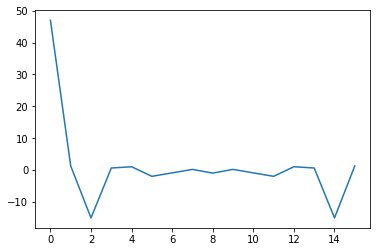

In [6]:
plt.plot(F)

In [9]:
F1 =np.array([ 47.        +0.j        ,   1.24830288+6.04100924j,
       -15.07106781-7.24264069j,   0.59945618+3.74490864j,
         1.        +0.j        ,  -2.01366975-0.49773204j,
        -0.92893219-1.24264069j,   0.16591068+1.79836855j,
        0.       ,   0.16591068-1.79836855j,
        -0.92893219+1.24264069j,  -2.01366975+0.49773204j,
         1.        +0.j        ,   0.59945618-3.74490864j,
       -15.07106781+7.24264069j,   1.24830288-6.04100924j])

In [15]:
print(F1)

[ 47.        +0.j           1.24830288+6.04100924j
 -15.07106781-7.24264069j   0.59945618+3.74490864j
   1.        +0.j          -2.01366975-0.49773204j
  -0.92893219-1.24264069j   0.16591068+1.79836855j
   0.        +0.j           0.16591068-1.79836855j
  -0.92893219+1.24264069j  -2.01366975+0.49773204j
   1.        +0.j           0.59945618-3.74490864j
 -15.07106781+7.24264069j   1.24830288-6.04100924j]


In [10]:
xi1 = np.fft.ifft(F1)

In [11]:
xi

array([1, 2, 3, 4, 5, 3, 1, 0, 1, 3, 4, 6, 5, 4, 3, 2])

In [12]:
xi1

array([ 1.0625+0.j,  1.9375+0.j,  3.0625+0.j,  3.9375+0.j,  5.0625+0.j,
        2.9375+0.j,  1.0625+0.j, -0.0625+0.j,  1.0625+0.j,  2.9375+0.j,
        4.0625+0.j,  5.9375+0.j,  5.0625+0.j,  3.9375+0.j,  3.0625+0.j,
        1.9375+0.j])

In [13]:
xi2 = np.fft.ifft(F)

In [14]:
xi

array([1, 2, 3, 4, 5, 3, 1, 0, 1, 3, 4, 6, 5, 4, 3, 2])